In [24]:
import cv2
import face_recognition
import numpy as np
import requests
from pymongo import MongoClient

# ✅ MongoDB Setup
client = MongoClient("mongodb://localhost:27017/")
db = client["attendance_system"]
users = db["users"]

# ✅ Download image from URL
def download_image(url):
    try:
        response = requests.get(url, timeout=10)
        image_array = np.frombuffer(response.content, np.uint8)
        return cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    except Exception as e:
        print(f"❌ Error downloading image: {e}")
        return None

# ✅ Get face encoding using face_recognition
def get_face_encoding(image):
    if image is None:
        return None

    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = face_recognition.face_locations(rgb_img)

    if not boxes:
        print("⚠️ No face detected.")
        return None

    encodings = face_recognition.face_encodings(rgb_img, boxes)
    if not encodings:
        print("⚠️ No encoding generated.")
        return None

    return encodings[0]

# ✅ Compute average of encodings
def compute_average_encoding(encodings):
    if not encodings or len(encodings) == 0:
        return None
    return np.mean(np.array(encodings), axis=0).tolist()


# ✅ Update user encodings
def update_user_encodings(email):
    user = users.find_one({"email": email})
    if not user:
        print("❌ User not found")
        return

    photo_urls = user.get("photo_links", [])
    existing_data = user.get("photo_data", [])
    existing_urls = set(entry.get("url") for entry in existing_data if "url" in entry)

    photo_data = existing_data.copy()
    encodings = []

    new_photos = [url for url in photo_urls if url not in existing_urls]
    
    if not new_photos:
        print("✅ No new photos to process.")
        return

    print(f"🔄 Processing {len(new_photos)} new photo(s)...")

    for url in new_photos:
        img = download_image(url)
        if img is None:
            print(f"⚠️ Failed to download: {url}")
            continue

        encoding = get_face_encoding(img)
        if encoding is None:
            print(f"⚠️ No valid face encoding found for: {url}")
            continue

        encoding = list(encoding)  # ensure JSON serializable
        photo_data.append({
            "url": url,
            "encoding": encoding
        })
        encodings.append(encoding)

    if not encodings:
        print("❌ No encodings extracted. Update aborted.")
        return

    avg_encoding = compute_average_encoding(encodings)

    users.update_one(
        {"email": email},
        {"$set": {
            "photo_data": photo_data,
            "average_encoding": avg_encoding
        }}
    )

    print(f"✅ {len(encodings)} new encodings stored for {email}")





# ✅ Example Usage
update_user_encodings("yashavinashmahajan664@gmail.com")


🔄 Processing 6 new photo(s)...
✅ 6 new encodings stored for yashavinashmahajan664@gmail.com


In [16]:
def update_all_users_encodings():
    all_users = users.find()
    count = 0

    for user in all_users:
        email = user.get("email")
        if not email:
            continue
        
        photo_links = user.get("photo_links", [])
        photo_data = user.get("photo_data", [])

        # Skip if all photos are already processed
        existing_urls = set(entry.get("url") for entry in photo_data if "url" in entry)
        new_photos = [url for url in photo_links if url not in existing_urls]
        
        if not new_photos:
            print(f"⏩ {email} - No new photos.")
            continue

        print(f"\n🟡 Updating: {email}")
        update_user_encodings(email)
        count += 1

    print(f"\n✅ Done. Updated {count} user(s) with new encodings.")


In [18]:
update_all_users_encodings()



🟡 Updating: 2023csb096.mohit@students.iiests.ac.in
🔄 Processing 11 new photo(s)...
✅ 11 new encodings stored for 2023csb096.mohit@students.iiests.ac.in
⏩ keshav1234bhagat@gmail.com - No new photos.

🟡 Updating: aniketnimje2003@gmail.com
🔄 Processing 1 new photo(s)...
⚠️ No face detected.
⚠️ No valid face encoding found for: https://res.cloudinary.com/dm5qtbeib/image/upload/v1749547606/djo8l31jiqzawf1edxvj.jpg
❌ No encodings extracted. Update aborted.
⏩ 2023csb107.yasharth@students.iiests.ac.in - No new photos.

🟡 Updating: nityashiv2808@gmail.com
🔄 Processing 2 new photo(s)...
⚠️ No face detected.
⚠️ No valid face encoding found for: https://res.cloudinary.com/dm5qtbeib/image/upload/v1749548892/wyoxoks3brhkl9bbrip8.jpg
⚠️ No face detected.
⚠️ No valid face encoding found for: https://res.cloudinary.com/dm5qtbeib/image/upload/v1749548929/rkxltuc5oi6bythdexkv.jpg
❌ No encodings extracted. Update aborted.

🟡 Updating: srivastavashreyansh04@gmail.com
🔄 Processing 9 new photo(s)...
✅ 9 new

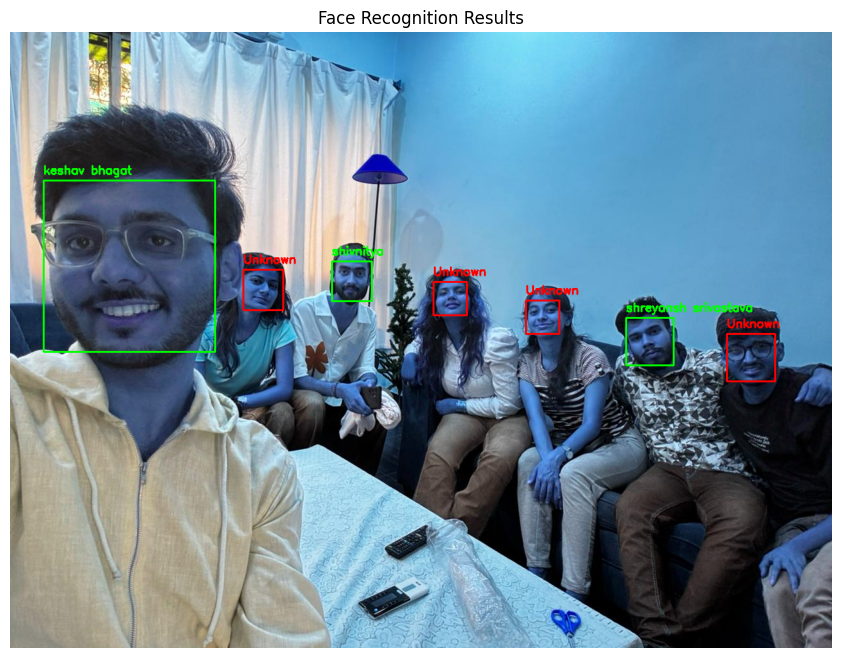

🧠 Face Detection Summary:
👥 Total Faces Detected: 7
✅ Matched Faces (Attendance Marked): 3
❌ Unmatched Faces: 4


In [32]:
from datetime import datetime
import cv2

def load_known_encodings():
    encodings = []
    emails = []
    names = []

    for user in users.find({"average_encoding": {"$ne": None}}):
        encodings.append(np.array(user["average_encoding"]))
        emails.append(user["email"])
        names.append(user["name"])
    
    return encodings, emails, names

# 🖼️ Load and detect faces in group image
def mark_attendance_from_group_image(image_path, tolerance=0.5):
    image = face_recognition.load_image_file(image_path)
    face_locations = face_recognition.face_locations(image)
    face_encodings = face_recognition.face_encodings(image, face_locations)

    known_encodings, known_emails, known_names = load_known_encodings()
    matched_indices = []

    total_detected = len(face_encodings)
    matched_count = 0

    for i, face_encoding in enumerate(face_encodings):
        matches = face_recognition.compare_faces(known_encodings, face_encoding, tolerance=tolerance)
        face_distances = face_recognition.face_distance(known_encodings, face_encoding)
        
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            email = known_emails[best_match_index]
            name = known_names[best_match_index]
            matched_indices.append((i, name, email))
            update_attendance(email)
            matched_count += 1

    draw_and_show(image, face_locations,face_encodings, matched_indices)

    # ✅ Summary output
    print("🧠 Face Detection Summary:")
    print(f"👥 Total Faces Detected: {total_detected}")
    print(f"✅ Matched Faces (Attendance Marked): {matched_count}")
    print(f"❌ Unmatched Faces: {total_detected - matched_count}")


def update_attendance(email):
    today = datetime.today().strftime("%Y-%m-%d")
    users.update_one(
        {"email": email, "attendance.present_dates": {"$ne": today}},
        {
            "$inc": {"attendance.days_present": 1},
            "$addToSet": {"attendance.present_dates": today}
        }
    )            

def draw_and_show(image, face_locations, face_encodings, matched_indices):
    matched_set = set(idx for idx, _, _ in matched_indices)

    for i, (top, right, bottom, left) in enumerate(face_locations):
        if i in matched_set:
            name = next(name for idx, name, _ in matched_indices if idx == i)
            color = (0, 255, 0)  # Green for matched
        else:
            name = "Unknown"
            color = (0, 0, 255)  # Red for unmatched

        cv2.rectangle(image, (left, top), (right, bottom), color, 2)
        cv2.putText(image, name, (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Show image using matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Face Recognition Results")
    plt.show()




# 🚀 Call the function with your group photo
mark_attendance_from_group_image("D:/attendance_system/WhatsApp Image 2025-06-11 at 02.24.47 (1).jpeg")

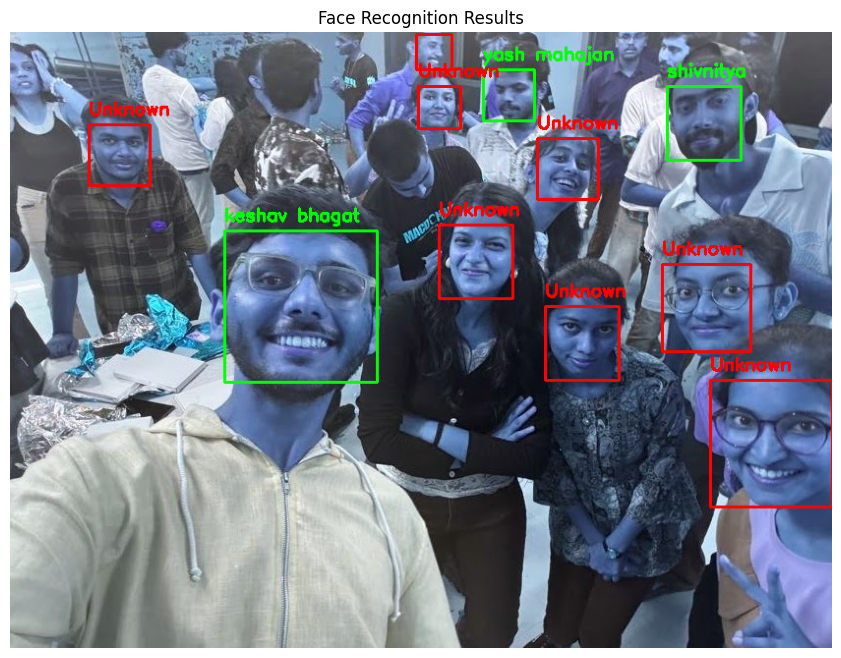

🧠 Face Detection Summary:
👥 Total Faces Detected: 11
✅ Matched Faces (Attendance Marked): 3
❌ Unmatched Faces: 8


In [34]:
mark_attendance_from_group_image("D:/New folder/yash/IMG_7948.jpg")